"As a first demonstration of the ability of this algorithm to recover the latent structure responsible
for having generated observed data, we applied the Gibbs sampler for the infinite linear-Gaussian
model to a simulated data set consisting of 100 6×6 images, each generated by randomly assigning
a feature to each image to a class with probability 0.5, and taking a linear combination of the
weights associated with features to which the images were assigned (a similar data set was used by
Ghahramani, 1995).  The non-zero elements of A were all equal to 1.0, and σX was set to
0.5, introducing a large amount of noise. The data were generated from a model with K+ = 4"

In [345]:
import math
import numpy as np
import time
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

In [346]:
np.random.seed(123)
N = 100 
K_plus = 4 
D = 36 
sigmaX = 0.5

# Simulated data based on the example in the paper
A = np.array(( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, \
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,1, 1, 1,0, 0, 0,  1, 0, 1, 0, 0, 0, 1, 1, 1,    \
             1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0,0, 0, 0, 0, 0,0 ,0, 0, \
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,0, 0, 0, 0,1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)).reshape(4, D)

Z_zero = np.zeros((N, K_plus))
X = np.zeros((N, D))
I = np.identity(D) * sigmaX

for i in range(N):
    Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    while (np.sum(Z_zero[i,:]) == 0):
        Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    X[i,:] = np.random.normal(0,1, (1,D)).dot(I)+Z_zero[i,:].dot(A)


In [348]:
#prior of IBP
def IBP_prior(alpha, N):
    res = np.zeros((N, 1000))

    #First person
    temp = np.random.poisson(alpha)
    if temp>0:
        res[0,0:temp] = np.ones(temp)

    #the rest with Bernoulli + Poisson
    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
    #sample as Bernoulli with rate m_k/i
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
    #The "untouched" dishes are got from poisson distribution with rate alpha/i
        temp = np.random.poisson(alpha/(i+1))
    #None zero
        if temp > 0:
    #The "new dishes", silimar logic as the very first person
            res[i, K_plus : K_plus + temp] = np.ones(temp)
    #length of new person's first few "bernoulli" choice 
            K_plus = K_plus + temp
    
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

In [362]:
#log p(X|Z,σ_x ,σ_A )

def log_p(X, Z, Sigma_X, Sigma_A, K, D, N):
    M = Z.T.dot(Z)+(Sigma_X**2/Sigma_A**2)*np.identity(K)
    #first term
#     log_first_term = (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(M))
    #exponential term
    log_exponential_term = -.5/(sigmaX**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)) )).dot(X))
    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(M)) + log_exponential_term

In [353]:
# define a log likelihood function 
def log_p(X, Z, sigmaX, sigmaA, K, D, N):
    M = Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)
    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(M)) \
        -.5/(sigmaX**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)) )).dot(X) )

"The Gibbs sampler was initialized with K+ = 1, choosing the feature assignments for the first
column by setting zi1 = 1 with probability 0.5. σA, σX , and α were initially set to 0.5, 1.7, and
1 respectively"

In [363]:
alpha = 1
sigmaA =0.5
Z, Kplus = IBP_prior(alpha, N)
%timeit log_p(X, Z, sigmaX, sigmaA, Kplus , D, N)

The slowest run took 5.83 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 292 µs per loop


In [ ]:
def sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew):
    SAMPLE_SIZE=niter-BURN_IN
    
    final_Z=np.zeros((SAMPLE_SIZE,N,20))
    final_K=np.zeros((SAMPLE_SIZE,1))
    final_sigma_X=np.zeros((SAMPLE_SIZE,1))
    final_sigma_A=np.zeros((SAMPLE_SIZE,1))
    final_alpha=np.zeros((SAMPLE_SIZE,1))
    Z, Kplus = IBP_prior(alpha, N)
    count=0

    for j in range(niter):
        if((j+1) > BURN_IN):
            final_Z[count,:,0:Kplus] = Z
            final_K[count] = Kplus
            final_sigma_X[count] = sigmaX
            final_sigma_A[count] = sigmaA
            final_alpha[count] = alpha
            count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           
           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  
            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )

        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        
        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z)

parameters α, σX , and σA over 1000 iterations of sampling.

In [ ]:
%%time
niter = 1000
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN


chain_Z, chain_K, chain_sigma_A, chain_sigma_X, chain_alpha, Z= sampler(X, niter, BURN_IN, sigmaX, sigmaA,alpha, N, D, maxNew)

In [86]:
Z_final=Z[:,0:4]

XRecreated=np.zeros((N,D))
Z=Z[:,0:4]
sigma_X=chain_sigma_X[SAMPLE_SIZE-1]
sigma_A=chain_sigma_A[SAMPLE_SIZE-1]
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z.T,Z)+(sigmaX/sigmaA)*np.eye(4))),Z.T),X)

for i in range(N):
    XRecreated[i,:]=np.dot(Z_final[i,:],A_inf[0:4,])

100 images were generated as binary linear combinations of four sets of
class weights, shown in the images on the top. The images on the bottom are the posterior
mean weights A for a single sample of Z after 200 iterations, ordered to match the true
classes. 

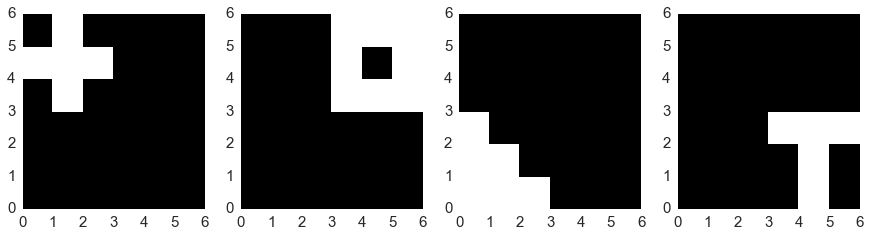

In [87]:
#Initial plots
plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(A[3,:].reshape(6,6),cmap=plt.cm.gray) 

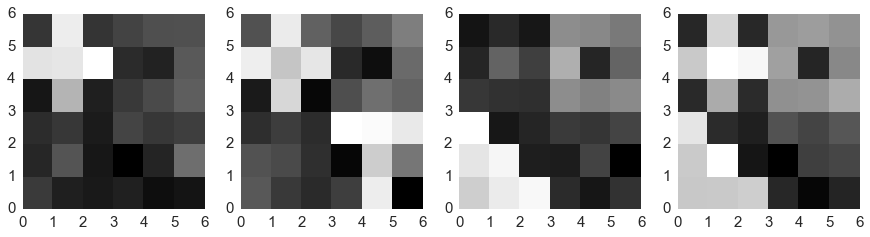

In [192]:

plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(XRecreated[9,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(142)
plt.pcolormesh(XRecreated[74,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(143)
plt.pcolormesh(XRecreated[10,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(144)
plt.pcolormesh(XRecreated[21,:].reshape(6,6),cmap=plt.cm.gray)

From left to right: 1000, 1001, 0110, 1110
